#Data


##Importing and parsing data


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.distributed as dist
from scipy import signal
from scipy.misc import electrocardiogram
import scipy

import csv
from collections import namedtuple
import matplotlib.pyplot as plt

# patient, experiment (OA), datetime, experiment-segment(perturbation, normal, VR),
# muscle location, bio-signal, experiment time
#structure: patient(experiment(location(time+data(muscle i.e. head, lateral(left/right(data)))))) 
#Signal = namedtuple('Signal', 'emgtime emgGastLatHeadR emgGastLatHeadL accGastLatHeadRX accGastLatHeadRY accGastLatHeadRZ emgGastMedHeadL emgGastMedHeadR')
#Patient = namedtuple('patient', 'perturbation normal VR')

# Initializing variables
rows, rows2, rows3, rows4 = [], [], [], []

acc_samp_rate = 148 #actual 148.15 
emg_samp_rate = 1926 #actual 1925.92

emgt, emgGastLatHeadR, emgGastLatHeadL, emgGastMedHeadL, emgGastMedHeadR = [],[],[],[],[]
acct, accGastLatHeadRX, accGastLatHeadRY, accGastLatHeadRZ = [],[],[],[] 
accGastMedHeadRX, accGastMedHeadRY, accGastMedHeadRZ = [],[],[] 

emgt2, emgGastLatHeadR2, emgGastLatHeadL2, emgGastMedHeadL2, emgGastMedHeadR2 = [],[],[],[],[]
acct2, accGastLatHeadRX2, accGastLatHeadRY2, accGastLatHeadRZ2 = [],[],[],[] 
accGastMedHeadRX2, accGastMedHeadRY2, accGastMedHeadRZ2 = [],[],[] 

emgt3, emgGastLatHeadR3, emgGastLatHeadL3, emgGastMedHeadL3, emgGastMedHeadR3 = [],[],[],[],[]
acct3, accGastLatHeadRX3, accGastLatHeadRY3, accGastLatHeadRZ3 = [],[],[],[] 
accGastMedHeadRX3, accGastMedHeadRY3, accGastMedHeadRZ3 = [],[],[] 

emgt4, emgGastLatHeadR4, emgGastLatHeadL4, emgGastMedHeadL4, emgGastMedHeadR4 = [],[],[],[],[]
acct4, accGastLatHeadRX4, accGastLatHeadRY4, accGastLatHeadRZ4 = [],[],[],[] 
accGastMedHeadRX4, accGastMedHeadRY4, accGastMedHeadRZ4 = [],[],[] 

L_PECTORALIS_MAJOR_EKG_16, ekgt = [], []
L_PECTORALIS_MAJOR_EKG_162, ekgt2 = [], []
L_PECTORALIS_MAJOR_EKG_163, ekgt3 = [], []
L_PECTORALIS_MAJOR_EKG_164, ekgt4 = [], []

Tibialis = []
LGastro_lat_hx, LGastro_lat_hy = [],[]
LGastro_lat_hz = []
RGastro_lat_h = []
Tibialistime = []

Tibialis2 = []
LGastro_lat_hx2, LGastro_lat_hy2 = [],[]
LGastro_lat_hz2 = []
RGastro_lat_h2 = []
Tibialistime2 = []

Tibialis3 = []
LGastro_lat_hx3, LGastro_lat_hy3 = [],[]
LGastro_lat_hz3 = []
RGastro_lat_h3 = []
Tibialistime3 = []

Tibialis4 = []
LGastro_lat_hx4, LGastro_lat_hy4 = [],[]
LGastro_lat_hz4 = []
RGastro_lat_h4 = []
Tibialistime4 = []


Trigno_sensor_3_Acc_3_x, Trigno_sensor_3_EMG_3 = [], []
Trigno_Mini_sensor_5_EMG_5, Trigno_Mini_sensor_5_Acc_5_X =  [],[]
Trigno_Trigger_sensor_15_Trig_15 = []

Trigno_sensor_3_Acc_3_x2, Trigno_sensor_3_EMG_32 = [], []
Trigno_Mini_sensor_5_EMG_52, Trigno_Mini_sensor_5_Acc_5_X2 =  [],[]
Trigno_Trigger_sensor_15_Trig_152 = []

Trigno_sensor_3_Acc_3_x3, Trigno_sensor_3_EMG_33 = [], []
Trigno_Mini_sensor_5_EMG_53, Trigno_Mini_sensor_5_Acc_5_X3 =  [],[]
Trigno_Trigger_sensor_15_Trig_153 = []

Trigno_sensor_3_Acc_3_x4, Trigno_sensor_3_EMG_34 = [], []
Trigno_Mini_sensor_5_EMG_54, Trigno_Mini_sensor_5_Acc_5_X4 =  [],[]
Trigno_Trigger_sensor_15_Trig_154 = []



#Sure thing, EKG file should be in the EMG file I shared with you already, it should be the last sensor(sensor16 L PECTORALIS MAJOR).
#'OA_2019_302_B_MVIC__L_Rectus_F__Rep_13'
#OA_2019_302_B_MVIC__Plantarflexors-R_T1_Rep_1.7
#OA_2019_302_B_MVIC__Plantarflexors-R_T2_Rep_1.8
#OA_2019_302_B_MVIC__Plantarflexors-R_T3_Rep_1.9
#OA_2019_302_B_MVIC__Plantarflexors-_L_T3_Rep_1.12
#OA_2019_302_B_MVIC__Plantarflexors_L_T1_Rep_1.10
#OA_2019_302_B_MVIC__Plantarflexors_L_T2_Rep_1.11
#OA_2019_302_B_MVIC__R._Tib_Rep_1.5
#OA_2019_302_B_MVIC__R_Bicep_F_Rep_1.2

'''
OA_2019_302_P1_Rep_1.3
OA_2019_302_P2_Rep_1.4
OA_2019_302_NW1_Rep_1.2
OA_2019_302_NW2_Rep_1.5
'''


gdrive = True
data_dir = '/csv'

file = gdrive_dir*gdrive +  '/OA_2019_302_NW1_Rep_1.2.csv'
file2 = gdrive_dir*gdrive + '/OA_2019_302_NW2_Rep_1.5.csv'
file3 = gdrive_dir*gdrive + '/OA_2019_302_P1_Rep_1.3.csv'
file4 = gdrive_dir*gdrive + '/OA_2019_302_P2_Rep_1.4.csv'

with open(file, newline='') as csvfile:
     spamreader = csv.reader(csvfile)

     for row in spamreader:
         emgt.append(row[0])
         acct.append(row[2])

         emgGastLatHeadR.append(row[1])
         accGastLatHeadRX.append(row[3])
         accGastLatHeadRY.append(row[5])
         accGastLatHeadRZ.append(row[7])
         emgGastMedHeadR.append(row[9])
         accGastMedHeadRX.append(row[11])
         accGastMedHeadRY.append(row[13])
         accGastMedHeadRZ.append(row[15])
         ekgt.append(row[114]) 
         L_PECTORALIS_MAJOR_EKG_16.append(row[115]) 
         
         Tibialistime.append(row[58])
         Tibialis.append(row[59])
         
         LGastro_lat_hx.append(row[83])
         LGastro_lat_hy.append(row[85])
         LGastro_lat_hz.append(row[87])
         RGastro_lat_h.append(row[111])

         Trigno_sensor_3_Acc_3_x.append(row[19])
         Trigno_sensor_3_EMG_3.append(row[17])
         Trigno_Mini_sensor_5_EMG_5.append(row[33])
         Trigno_Mini_sensor_5_Acc_5_X.append(row[35])
         Trigno_Trigger_sensor_15_Trig_15.append(row[113]) 



         rows.append(row)
L_PECTORALIS_MAJOR_EKG_16.pop(0)
ekgt.pop(0)         
emgt.pop(0)
emgGastLatHeadR.pop(0)
acct.pop(0)
accGastLatHeadRX.pop(0)
accGastLatHeadRY.pop(0)
accGastLatHeadRZ.pop(0)
emgGastMedHeadR.pop(0)
accGastMedHeadRX.pop(0)
accGastMedHeadRY.pop(0)
accGastMedHeadRZ.pop(0)

Tibialistime.pop(0)
Tibialis.pop(0)
LGastro_lat_hx.pop(0)
LGastro_lat_hy.pop(0)
LGastro_lat_hz.pop(0)
RGastro_lat_h.pop(0)

Trigno_sensor_3_Acc_3_x.pop(0)
Trigno_sensor_3_EMG_3.pop(0)
Trigno_Mini_sensor_5_EMG_5.pop(0)
Trigno_Mini_sensor_5_Acc_5_X.pop(0)
Trigno_Trigger_sensor_15_Trig_15.pop(0)


acct = np.asarray(acct[0:1846]).astype(np.float)
emgt = [w if w!='' else 0 for w in emgt ] #replace empty values at end with zeroes
emgt = np.asarray(emgt).astype(np.float)
ekgt = [w if w!='' else 0 for w in ekgt ]
ekgt = np.asarray(ekgt).astype(np.float)
L_PECTORALIS_MAJOR_EKG_16 = np.asarray(L_PECTORALIS_MAJOR_EKG_16).astype(np.float)

emgGastLatHeadR = np.asarray(emgGastLatHeadR).astype(np.float)
emgGastMedHeadR = np.asarray(emgGastMedHeadR).astype(np.float)

accGastLatHeadRX = np.asarray(accGastLatHeadRX[0:1846]).astype(np.float)
accGastLatHeadRY = np.asarray(accGastLatHeadRY[0:1846]).astype(np.float)
accGastLatHeadRZ = np.asarray(accGastLatHeadRZ[0:1846]).astype(np.float)

accGastMedHeadRX = np.asarray(accGastMedHeadRX[0:1846]).astype(np.float)
accGastMedHeadRY = np.asarray(accGastMedHeadRY[0:1846]).astype(np.float)
accGastMedHeadRZ = np.asarray(accGastMedHeadRZ[0:1846]).astype(np.float)

Tibialistime = [w if w!='' else 0 for w in Tibialistime ]
Tibialis = [w if w!='' else 0 for w in Tibialis ]
LGastro_lat_hx = [w if w!='' else 0 for w in LGastro_lat_hx ]
LGastro_lat_hy = [w if w!='' else 0 for w in LGastro_lat_hy ]
LGastro_lat_hz = [w if w!='' else 0 for w in LGastro_lat_hz ]
RGastro_lat_h = [w if w!='' else 0 for w in RGastro_lat_h ]

Tibialis = np.asarray(Tibialis).astype(np.float)
Tibialistime = np.asarray(Tibialistime).astype(np.float)
LGastro_lat_hx = np.asarray(LGastro_lat_hx).astype(np.float)
LGastro_lat_hy = np.asarray(LGastro_lat_hy).astype(np.float)
LGastro_lat_hz = np.asarray(LGastro_lat_hz).astype(np.float)
RGastro_lat_h = np.asarray(RGastro_lat_h).astype(np.float)




with open(file2, newline='') as csvfile:
     spamreader = csv.reader(csvfile)
     for row in spamreader:
         ekgt2.append(row[114]) 
         L_PECTORALIS_MAJOR_EKG_162.append(row[115]) 
         emgt2.append(row[0])
         acct2.append(row[2])

         emgGastLatHeadR2.append(row[1])
         accGastLatHeadRX2.append(row[3])
         accGastLatHeadRY2.append(row[5])
         accGastLatHeadRZ2.append(row[7])
         emgGastMedHeadR2.append(row[9])
         accGastMedHeadRX2.append(row[11])
         accGastMedHeadRY2.append(row[13])
         accGastMedHeadRZ2.append(row[15])
         ekgt2.append(row[114]) 
         
         Tibialistime2.append(row[58])
         Tibialis2.append(row[59])
         
         LGastro_lat_hx2.append(row[83])
         LGastro_lat_hy2.append(row[85])
         LGastro_lat_hz2.append(row[87])
         RGastro_lat_h2.append(row[111])
         rows2.append(row)
L_PECTORALIS_MAJOR_EKG_162.pop(0)
ekgt2.pop(0)
emgt2.pop(0)
emgGastLatHeadR2.pop(0)
acct2.pop(0)
accGastLatHeadRX2.pop(0)
accGastLatHeadRY2.pop(0)
accGastLatHeadRZ2.pop(0)
emgGastMedHeadR2.pop(0)
accGastMedHeadRX2.pop(0)
accGastMedHeadRY2.pop(0)
accGastMedHeadRZ2.pop(0)
Tibialistime2.pop(0)
Tibialis2.pop(0)
LGastro_lat_hx2.pop(0)
LGastro_lat_hy2.pop(0)
LGastro_lat_hz2.pop(0)
RGastro_lat_h2.pop(0)

acct2 = np.asarray(acct2[0:1846]).astype(np.float)
emgt2 = [w if w!='' else 0 for w in emgt2 ]
emgt2 = np.asarray(emgt2).astype(np.float)

ekgt2 = [w if w!='' else 0 for w in ekgt2 ]
ekgt2 = (ekgt2[::-416])
ekgt2 = np.asarray(ekgt2).astype(np.float)

L_PECTORALIS_MAJOR_EKG_162 = np.asarray(L_PECTORALIS_MAJOR_EKG_162).astype(np.float)

emgGastLatHeadR2 = np.asarray(emgGastLatHeadR2).astype(np.float)
emgGastMedHeadR2 = np.asarray(emgGastMedHeadR2).astype(np.float)

accGastLatHeadRX2 = np.asarray(accGastLatHeadRX2[0:1846]).astype(np.float)
accGastLatHeadRY2 = np.asarray(accGastLatHeadRY2[0:1846]).astype(np.float)
accGastLatHeadRZ2 = np.asarray(accGastLatHeadRZ2[0:1846]).astype(np.float)

accGastMedHeadRX2 = np.asarray(accGastMedHeadRX2[0:1846]).astype(np.float)
accGastMedHeadRY2 = np.asarray(accGastMedHeadRY2[0:1846]).astype(np.float)
accGastMedHeadRZ2 = np.asarray(accGastMedHeadRZ2[0:1846]).astype(np.float)

Tibialistime2 = [w if w!='' else 0 for w in Tibialistime2 ]
Tibialis2 = [w if w!='' else 0 for w in Tibialis2 ]
LGastro_lat_hx2 = [w if w!='' else 0 for w in LGastro_lat_hx2 ]
LGastro_lat_hy2 = [w if w!='' else 0 for w in LGastro_lat_hy2 ]
LGastro_lat_hz2 = [w if w!='' else 0 for w in LGastro_lat_hz2 ]
RGastro_lat_h2 = [w if w!='' else 0 for w in RGastro_lat_h2 ]

Tibialis2 = np.asarray(Tibialis2).astype(np.float)
Tibialistime2 = np.asarray(Tibialistime2).astype(np.float)
LGastro_lat_hx2 = np.asarray(LGastro_lat_hx2).astype(np.float)
LGastro_lat_hy2 = np.asarray(LGastro_lat_hy2).astype(np.float)
LGastro_lat_hz2 = np.asarray(LGastro_lat_hz2).astype(np.float)
RGastro_lat_h2 = np.asarray(RGastro_lat_h2).astype(np.float)





with open(file3, newline='') as csvfile:
     spamreader = csv.reader(csvfile)
     for row in spamreader:
         ekgt3.append(row[114]) 
         L_PECTORALIS_MAJOR_EKG_163.append(row[115]) 
         rows3.append(row)
         emgt3.append(row[0])
         acct3.append(row[2])

         emgGastLatHeadR3.append(row[1])
         accGastLatHeadRX3.append(row[3])
         accGastLatHeadRY3.append(row[5])
         accGastLatHeadRZ3.append(row[7])
         emgGastMedHeadR3.append(row[9])
         accGastMedHeadRX3.append(row[11])
         accGastMedHeadRY3.append(row[13])
         accGastMedHeadRZ3.append(row[15])
         
         Tibialistime3.append(row[58])
         Tibialis3.append(row[59])
         
         LGastro_lat_hx3.append(row[83])
         LGastro_lat_hy3.append(row[85])
         LGastro_lat_hz3.append(row[87])
         RGastro_lat_h3.append(row[111])



         rows3.append(row)
L_PECTORALIS_MAJOR_EKG_163.pop(0)
ekgt3.pop(0)         
emgt3.pop(0)
emgGastLatHeadR3.pop(0)
acct3.pop(0)
accGastLatHeadRX3.pop(0)
accGastLatHeadRY3.pop(0)
accGastLatHeadRZ3.pop(0)
emgGastMedHeadR3.pop(0)
accGastMedHeadRX3.pop(0)
accGastMedHeadRY3.pop(0)
accGastMedHeadRZ3.pop(0)

Tibialistime3.pop(0)
Tibialis3.pop(0)
LGastro_lat_hx3.pop(0)
LGastro_lat_hy3.pop(0)
LGastro_lat_hz3.pop(0)
RGastro_lat_h3.pop(0)

acct3 = np.asarray(acct3[0:1846]).astype(np.float)

emgt3 = [w if w!='' else 0 for w in emgt3 ] #replace empty values at end with zeroes
emgt3 = np.asarray(emgt3).astype(np.float)

ekgt3 = [w if w!='' else 0 for w in ekgt3 ]
ekgt3 = np.asarray(ekgt3).astype(np.float)
ekgt3 = (ekgt3[::-312])

L_PECTORALIS_MAJOR_EKG_163 = np.asarray(L_PECTORALIS_MAJOR_EKG_163).astype(np.float)

emgGastLatHeadR3 = np.asarray(emgGastLatHeadR3).astype(np.float)
emgGastMedHeadR3 = np.asarray(emgGastMedHeadR3).astype(np.float)

accGastLatHeadRX3 = np.asarray(accGastLatHeadRX3[0:1846]).astype(np.float)
accGastLatHeadRY3 = np.asarray(accGastLatHeadRY3[0:1846]).astype(np.float)
accGastLatHeadRZ3 = np.asarray(accGastLatHeadRZ3[0:1846]).astype(np.float)

accGastMedHeadRX3 = np.asarray(accGastMedHeadRX3[0:1846]).astype(np.float)
accGastMedHeadRY3 = np.asarray(accGastMedHeadRY3[0:1846]).astype(np.float)
accGastMedHeadRZ3 = np.asarray(accGastMedHeadRZ3[0:1846]).astype(np.float)

Tibialistime3 = [w if w!='' else 0 for w in Tibialistime3 ]
Tibialis3 = [w if w!='' else 0 for w in Tibialis3 ]
LGastro_lat_hx3 = [w if w!='' else 0 for w in LGastro_lat_hx3 ]
LGastro_lat_hy3 = [w if w!='' else 0 for w in LGastro_lat_hy3 ]
LGastro_lat_hz3 = [w if w!='' else 0 for w in LGastro_lat_hz3 ]
RGastro_lat_h3 = [w if w!='' else 0 for w in RGastro_lat_h3 ]

Tibialis3 = np.asarray(Tibialis3).astype(np.float)
Tibialistime3 = np.asarray(Tibialistime3).astype(np.float)
LGastro_lat_hx3 = np.asarray(LGastro_lat_hx3).astype(np.float)
LGastro_lat_hy3 = np.asarray(LGastro_lat_hy3).astype(np.float)
LGastro_lat_hz3 = np.asarray(LGastro_lat_hz3).astype(np.float)
RGastro_lat_h3 = np.asarray(RGastro_lat_h3).astype(np.float)



with open(file4, newline='') as csvfile:
     spamreader = csv.reader(csvfile)
     for row in spamreader:
         ekgt4.append(row[114]) 
         L_PECTORALIS_MAJOR_EKG_164.append(row[115]) 
         rows4.append(row)
         emgt4.append(row[0])
         acct4.append(row[2])

         emgGastLatHeadR4.append(row[1])
         accGastLatHeadRX4.append(row[3])
         accGastLatHeadRY4.append(row[5])
         accGastLatHeadRZ4.append(row[7])
         emgGastMedHeadR4.append(row[9])
         accGastMedHeadRX4.append(row[11])
         accGastMedHeadRY4.append(row[13])
         accGastMedHeadRZ4.append(row[15])
         
         Tibialistime4.append(row[58])
         Tibialis4.append(row[59])
         
         LGastro_lat_hx4.append(row[83])
         LGastro_lat_hy4.append(row[85])
         LGastro_lat_hz4.append(row[87])
         RGastro_lat_h4.append(row[111])



         rows4.append(row)
L_PECTORALIS_MAJOR_EKG_164.pop(0)
ekgt4.pop(0)         
emgt4.pop(0)
emgGastLatHeadR4.pop(0)
acct4.pop(0)
accGastLatHeadRX4.pop(0)
accGastLatHeadRY4.pop(0)
accGastLatHeadRZ4.pop(0)
emgGastMedHeadR4.pop(0)
accGastMedHeadRX4.pop(0)
accGastMedHeadRY4.pop(0)
accGastMedHeadRZ4.pop(0)

Tibialistime4.pop(0)
Tibialis4.pop(0)
LGastro_lat_hx4.pop(0)
LGastro_lat_hy4.pop(0)
LGastro_lat_hz4.pop(0)
RGastro_lat_h4.pop(0)

acct4 = np.asarray(acct4[0:1846]).astype(np.float)

emgt4 = [w if w!='' else 0 for w in emgt4 ] #replace empty values at end with zeroes
emgt4 = np.asarray(emgt4).astype(np.float)

ekgt4 = [w if w!='' else 0 for w in ekgt4 ]
ekgt4 = np.asarray(ekgt4).astype(np.float)
L_PECTORALIS_MAJOR_EKG_164 = np.asarray(L_PECTORALIS_MAJOR_EKG_164).astype(np.float)

emgGastLatHeadR4 = np.asarray(emgGastLatHeadR4).astype(np.float)
emgGastMedHeadR4 = np.asarray(emgGastMedHeadR4).astype(np.float)

accGastLatHeadRX4 = np.asarray(accGastLatHeadRX4[0:1846]).astype(np.float)
accGastLatHeadRY4 = np.asarray(accGastLatHeadRY4[0:1846]).astype(np.float)
accGastLatHeadRZ4 = np.asarray(accGastLatHeadRZ4[0:1846]).astype(np.float)

accGastMedHeadRX4 = np.asarray(accGastMedHeadRX4[0:1846]).astype(np.float)
accGastMedHeadRY4 = np.asarray(accGastMedHeadRY4[0:1846]).astype(np.float)
accGastMedHeadRZ4 = np.asarray(accGastMedHeadRZ4[0:1846]).astype(np.float)

Tibialistime4 = [w if w!='' else 0 for w in Tibialistime4 ]
Tibialis4 = [w if w!='' else 0 for w in Tibialis4 ]
LGastro_lat_hx4 = [w if w!='' else 0 for w in LGastro_lat_hx4 ]
LGastro_lat_hy4 = [w if w!='' else 0 for w in LGastro_lat_hy4 ]
LGastro_lat_hz4 = [w if w!='' else 0 for w in LGastro_lat_hz4 ]
RGastro_lat_h4F = [w if w!='' else 0 for w in RGastro_lat_h4 ]

Tibialis4 = np.asarray(Tibialis4).astype(np.float)
Tibialistime4 = np.asarray(Tibialistime4).astype(np.float)
LGastro_lat_hx4 = np.asarray(LGastro_lat_hx4).astype(np.float)
LGastro_lat_hy4 = np.asarray(LGastro_lat_hy4).astype(np.float)
LGastro_lat_hz4 = np.asarray(LGastro_lat_hz4).astype(np.float)
RGastro_lat_h4 = np.asarray(RGastro_lat_h4).astype(np.float)


file = gdrive_dir + '/OA_2019_302_NW2_Rep_1.5.csv'
file = file.replace('csv','txt')
file = open(file, 'w')
np.savetxt(file, L_PECTORALIS_MAJOR_EKG_16, fmt = '%10.15f')
file.close()
# Sampling Rate (Hz):= 1000.00
# Resolution:= 12
# Labels:= ECG


file2 = gdrive_dir*gdrive + '/OA_2019_302_NW2_Rep_1.2.csv'
file2 = file2.replace('csv','txt')
file2 = open(file2, 'w')
np.savetxt(file2, L_PECTORALIS_MAJOR_EKG_162, fmt = '%10.15f')
file2.close()

file3 = gdrive_dir*gdrive + '/OA_2019_302_P1_Rep_1.3.csv'
file3 = file3.replace('csv','txt')
file3 = open(file3, 'w')
np.savetxt(file3, L_PECTORALIS_MAJOR_EKG_163, fmt = '%10.15f')
file3.close()

file4 = gdrive_dir*gdrive + '/OA_2019_302_P2_Rep_1.4.csv'
file4 = file4.replace('csv','txt')
file4 = open(file4, 'w')
np.savetxt(file4, L_PECTORALIS_MAJOR_EKG_164, fmt = '%10.15f')
file4.close()


ImportError: cannot import name 'electrocardiogram'

In [1]:
import sys
print(sys.executable)


C:\ProgramData\Anaconda3\python.exe


In [ ]:
print(1/emgt[1])
print(1/acct[1])
print(1/ekgt[1])


1925.925811796989
148.14814814814815
1925.925811796989


##plots 

[-0.866102  -0.8620737 -0.8620737 ...  0.         0.         0.       ]


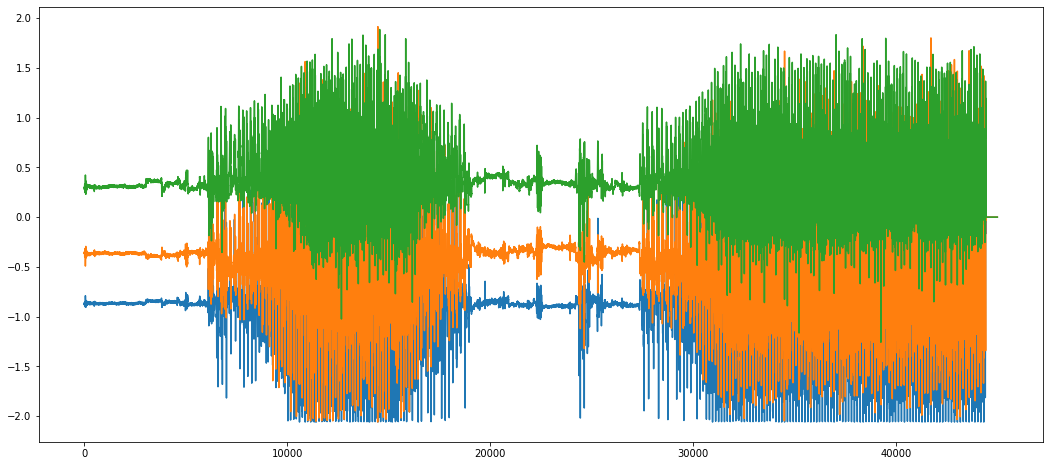

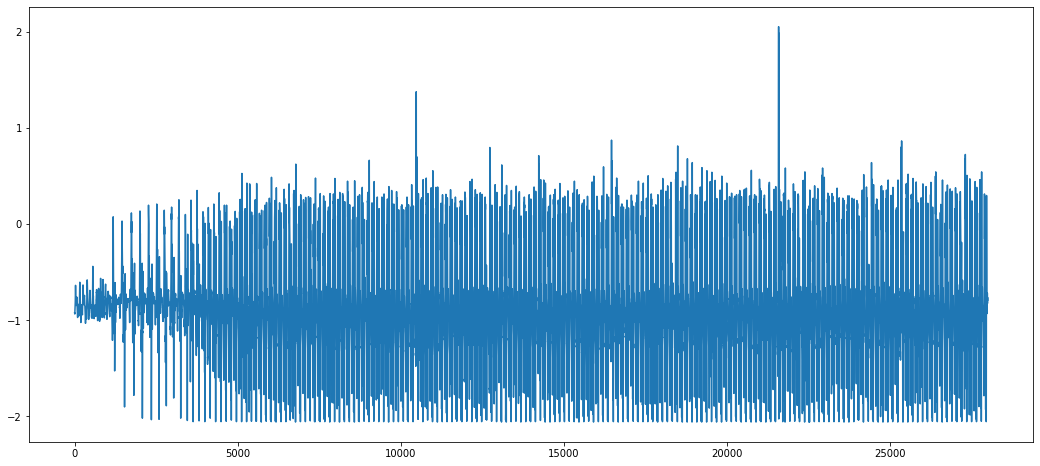

In [ ]:
print(LGastro_lat_hx[4:44500])

'''
plt.figure(figsize=(18,8))
print(Tibialistime[4:44500])
plt.plot(Tibialis[12000:13000])

plt.figure(figsize=(18,8))
print(Tibialistime[4:44500])
plt.plot(Tibialis[20000:40000])
'''

plt.figure(figsize=(18,8))
plt.plot(LGastro_lat_hx[5:45000])
plt.plot(LGastro_lat_hy[5:45000])
plt.plot(LGastro_lat_hz[5:45000])

#tri = np.sqrt(np.multiply(LGastro_lat_hx**2, LGastro_lat_hy**2, LGastro_lat_hz**2))
plt.figure(figsize=(18,8))
plt.plot(LGastro_lat_hx4[5:28000])


##plotting and filtering 

In [ ]:
#plt.axis('off')

#plt.plot(emgt)

plot = False
if plot:
      
    plt.figure(0)
    plt.subplot(2,1,1)

    ax = plt.plot(np.asarray(emgt), np.asarray(emgGastMedHeadR))


    Amp =  np.fft.rfft(emgGastMedHeadR)
    Freq = np.fft.rfftfreq(len(emgGastMedHeadR), d=1/emg_samp_rate)
    plt.subplot(2,1,2)

    print(len(Amp))
    print(len(Freq))

    bx = plt.plot(Freq, np.abs(Amp))
    #plt.ylim([0,8]);
    emgGastMedHeadR = np.asarray(emgGastMedHeadR)
    print(emgGastMedHeadR.shape)
    cutoff_freq = 30 * 2 /  emg_samp_rate
    b, a = signal.butter(5, cutoff_freq) #first parameter is signal order and the second one refers to frequenc limit. I set limit 30 so that I can see only below 30 frequency signal component
    output = signal.filtfilt(b, a, emgGastMedHeadR)

    #plt.savefig(gdrive_dir + '/fig0.png')


    plt.figure(1)
    plt.subplot(2,1,1)

    plt.plot(emgt,output)

    plt.subplot(2,1,2)
    Amp =  np.fft.rfft(output)
    Freq = np.fft.rfftfreq(len(output), d=1/emg_samp_rate)
    #plt.ylim([0,8]);
    plt.plot(Freq, np.abs(Amp))
    #plt.savefig(gdrive_dir + '/fig1.png')



    plt.figure(2)
    plt.subplot(2,1,1)
    plt.title('normalized acc data')
    plt.xlabel('time (s)')
    plt.plot(acct[10:84],accGastLatHeadRX[10:84]/max(accGastLatHeadRX))
    plt.plot(acct[10:84],abs(accGastLatHeadRY[10:84])/max(accGastLatHeadRY))
    plt.plot(acct[10:84],accGastLatHeadRZ[10:84]/max(accGastLatHeadRZ))

    plt.plot(acct[10:84],accGastMedHeadRX[10:84]/max(accGastMedHeadRX))
    plt.plot(acct[10:84],accGastMedHeadRY[10:84]/max(accGastMedHeadRY))
    plt.plot(acct[10:84],accGastMedHeadRZ[10:84]/max(accGastMedHeadRZ))
    plt.legend(['lrx', 'lry', 'lrz', 'mrx', 'mry', 'mrz'])

    plt.subplot(2,1,2)
    plt.title('emg data')
    plt.ylabel('mV')
    plt.plot(emgt[10:284],emgGastLatHeadR[10:284])
    plt.plot(emgt[10:284],emgGastMedHeadR[10:284])
    plt.xlabel('time (s)')
    plt.legend(['memg','lemg'])
    #plt.savefig(gdrive_dir + '/fig2.png')


    plt.figure()
    plt.title('normalized acc data')
    plt.xlabel('time (s)')

    print(len(Tibialis))
    print(len(acct))

    '''
    plt.plot(acct,Tibialis) #/max(accGastLatHeadRX))
    plt.plot(acct,LGastro_lat_h) #/max(accGastLatHeadRX))
    plt.plot(acct,RGastro_lat_h) #/max(accGastLatHeadRX))
    '''


In [ ]:
'''
'R RECTUS FEMORIS: EMG 1'
'R RECTUS FEMORIS: Acc 1.X'// Y // Z
'L RECTUS FEMORIS: EMG 2'
'L RECTUS FEMORIS: Acc 2.X'// Y // Z
'Trigno sensor 3: EMG 3'
'Trigno sensor 3: Acc 3.X'// Y // Z
'L BICEPS FEMORIS: EMG 4'
'L BICEPS FEMORIS: Acc 4.X'// Y // Z
'Trigno Mini sensor 5: EMG 5'
'Trigno Mini sensor 5: Acc 5.X'// Y // Z
'R BICEPS FEMORIS: EMG 6'
'R BICEPS FEMORIS: Acc 6.X'// Y // Z
'R TIBIALIS ANTERIOR: EMG 7'
'R TIBIALIS ANTERIOR: Acc 7.X'// Y // Z
'L TIBIALIS ANTERIOR: EMG 8'
'L TIBIALIS ANTERIOR: Acc 8.X'// Y // Z
'R TENSOR FASCIAE LATAE: EMG 9'
'R TENSOR FASCIAE LATAE: Acc 9.X'// Y // Z
'R VASTUS LATERALIS: EMG 10'
'R VASTUS LATERALIS: Acc 10.X'// Y // Z
'L GASTROCNEMIUS LATERAL HEAD: EMG 11'
'L GASTROCNEMIUS LATERAL HEAD: Acc 11.X' // Y // Z
'L GASTROCNEMIUS MEDIAL HEAD: EMG 12'
'L GASTROCNEMIUS MEDIAL HEAD: Acc 12.X'// Y // Z
'R GASTROCNEMIUS LATERAL HEAD: EMG 13'
'R GASTROCNEMIUS LATERAL HEAD: Acc 13.X'// Y // Z
'R GASTROCNEMIUS MEDIAL HEAD: EMG 14'
'R GASTROCNEMIUS MEDIAL HEAD: Acc 14.X'// Y // Z
'Trigno Trigger sensor 15: Trig 15'
'L PECTORALIS MAJOR: EKG 16'
'L PECTORALIS MAJOR: Acc 16.X'// Y // Z
'''
# 8*7 = Tibialis = [59]
# 8*11 = LGastro_lat_h = [88]
# 8/14 = RGastro_lat_h = [112]
# TIBIALIS
# TIBIALIS ANTERIOR
# GASTROCNEMIUS MEDIAL HEAD
# GASTROCNEMIUS LATERAL HEAD


print(rows[0])
print(rows2[0])
print(rows3[0])
print(rows4[0])
print(rows[0][113])

header = rows[0]
new_head= []
for i in range(len(header)//2):
  y = header[2*i+1]
  #print(y)
  y = y.replace(' ','_')
  y = y.replace(':','')
  y = y.replace('.','_')

  #print(y)
  new_head.append(y)
#print(header)
  
#header = [w if w!=':' else '_' for w in header ]
'''
print(len(header))
print(np.shape(header))
print(new_head)
print(np.shape(new_head))
'''
pass 

['X[s]', 'R RECTUS FEMORIS: EMG 1', 'X[s]', 'R RECTUS FEMORIS: Acc 1.X', 'X[s]', 'R RECTUS FEMORIS: Acc 1.Y', 'X[s]', 'R RECTUS FEMORIS: Acc 1.Z', 'X[s]', 'L RECTUS FEMORIS: EMG 2', 'X[s]', 'L RECTUS FEMORIS: Acc 2.X', 'X[s]', 'L RECTUS FEMORIS: Acc 2.Y', 'X[s]', 'L RECTUS FEMORIS: Acc 2.Z', 'X[s]', 'Trigno sensor 3: EMG 3', 'X[s]', 'Trigno sensor 3: Acc 3.X', 'X[s]', 'Trigno sensor 3: Acc 3.Y', 'X[s]', 'Trigno sensor 3: Acc 3.Z', 'X[s]', 'L BICEPS FEMORIS: EMG 4', 'X[s]', 'L BICEPS FEMORIS: Acc 4.X', 'X[s]', 'L BICEPS FEMORIS: Acc 4.Y', 'X[s]', 'L BICEPS FEMORIS: Acc 4.Z', 'X[s]', 'Trigno Mini sensor 5: EMG 5', 'X[s]', 'Trigno Mini sensor 5: Acc 5.X', 'X[s]', 'Trigno Mini sensor 5: Acc 5.Y', 'X[s]', 'Trigno Mini sensor 5: Acc 5.Z', 'X[s]', 'R BICEPS FEMORIS: EMG 6', 'X[s]', 'R BICEPS FEMORIS: Acc 6.X', 'X[s]', 'R BICEPS FEMORIS: Acc 6.Y', 'X[s]', 'R BICEPS FEMORIS: Acc 6.Z', 'X[s]', 'R TIBIALIS ANTERIOR: EMG 7', 'X[s]', 'R TIBIALIS ANTERIOR: Acc 7.X', 'X[s]', 'R TIBIALIS ANTERIOR: Acc

## Manual R-wave peak detection

457
1925.925811796989


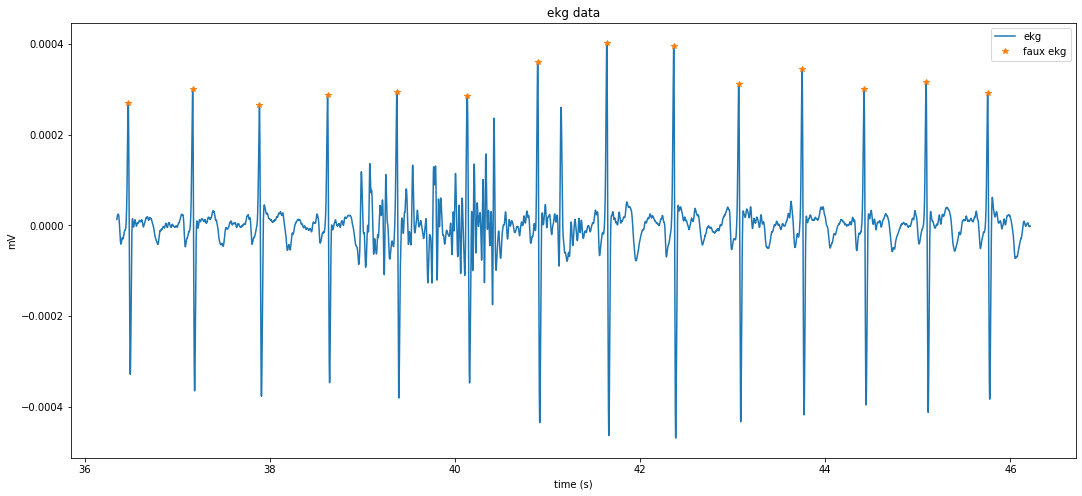

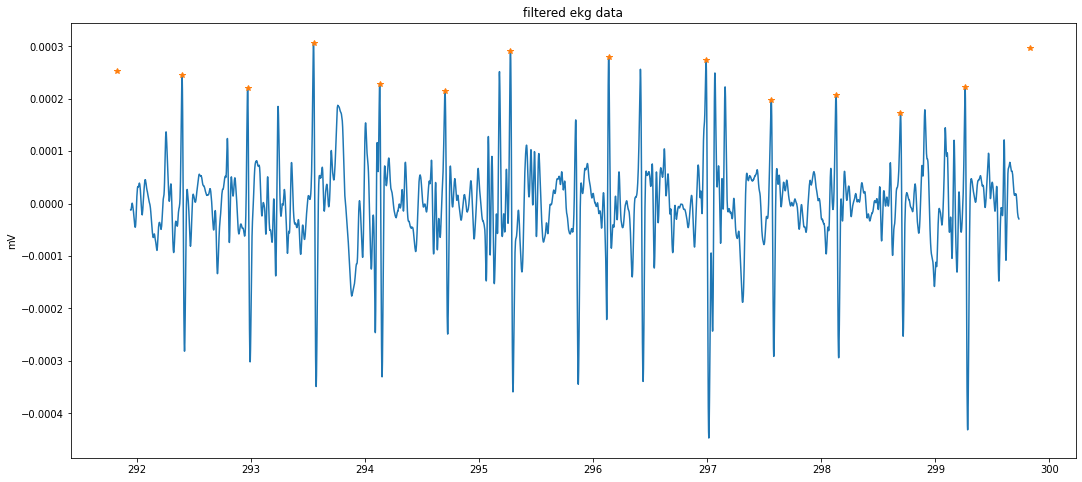

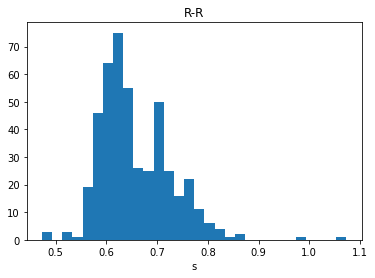

In [ ]:


plt.figure(3, figsize=(18,8))
plt.title('ekg data')
plt.xlabel('time (s)')
plt.ylabel('mV')

#plt.plot(ekgt[10:15000],L_PECTORALIS_MAJOR_EKG_16[10:15000])
plt.plot(ekgt[70000:89000],L_PECTORALIS_MAJOR_EKG_16[70000:89000])
peaks = None
peaks = scipy.signal.find_peaks( L_PECTORALIS_MAJOR_EKG_16 ,distance = 900, height=0.00005,prominence = 0.00005 )
# height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None
# distance calculated based on maximum beats per second at 207bpm 
peak_pos,peak_t = [],[]
#print(peaks[0])
for i in peaks[0]:
  
  peak_pos.append(L_PECTORALIS_MAJOR_EKG_16[i])
  peak_t.append(ekgt[i])
plt.plot(peak_t[51:65], peak_pos[51:65],'*')
#plt.plot(peak_t, peak_pos,'*')

ekgfake = electrocardiogram()
fs = 360
time = np.arange(ekgfake.size) / fs
#plt.plot(time[10:3000],ekgfake[10:3000]/5000)
plt.legend(['ekg', 'faux ekg'])
print(len(peak_t))
print(1/ekgt[1])
plt.savefig(gdrive_dir + '/fig3.png')


plt.figure(5, figsize=(18,8))
plt.plot(ekgt[-15900:-900],L_PECTORALIS_MAJOR_EKG_16[-15900:-900])
plt.ylabel('mV')
plt.title('filtered ekg data')


plt.plot(peak_t[-14::], peak_pos[-14::],'*')
plt.savefig(gdrive_dir + '/fig5.png')


plt.figure(4)
delta = np.ediff1d(peak_t)
plt.hist(delta, bins= 30);
plt.savefig(gdrive_dir + '/R-Rraw.png')
plt.xlabel('s')
plt.title('R-R')
plt.savefig(gdrive_dir + '/fig4.png')




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


457
454


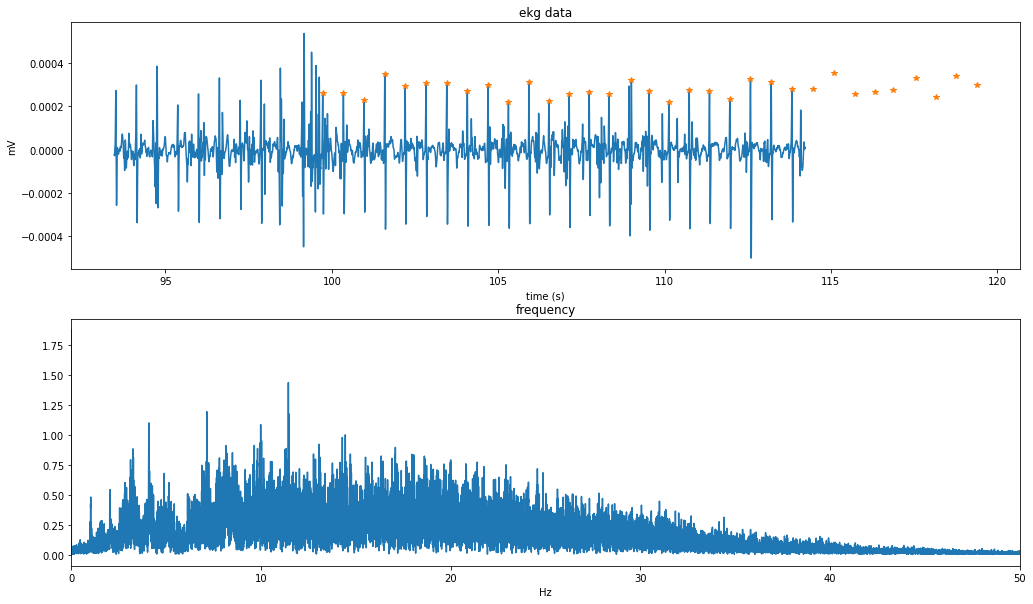

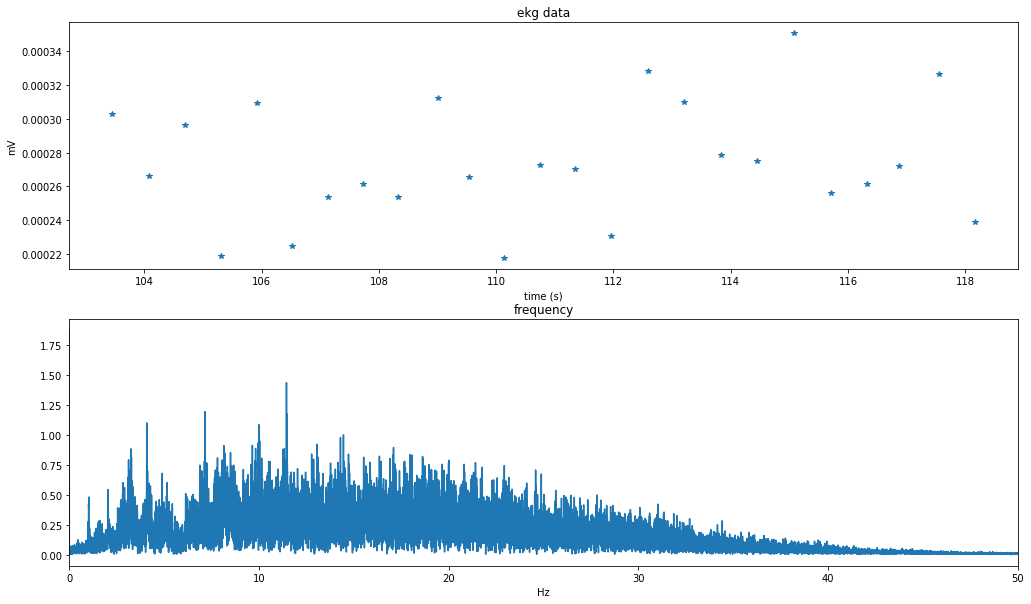

In [ ]:
plt.figure(6,figsize=(17,10))
plt.subplot(2,1,1)
ekg_samp_rate = np.round(1/ekgt[1])

plt.subplot(2,1,1)

ax = plt.plot(np.asarray(ekgt[180000:220000]), np.asarray(L_PECTORALIS_MAJOR_EKG_16[180000:220000]))
#plt.plot(peak_t[52:65], peak_pos[52:65],'*')
plt.plot(peak_t[145:178],peak_pos[145:178], '*')
#plt.plot(peak_t, peak_pos,'*')
Amp =  np.fft.rfft(L_PECTORALIS_MAJOR_EKG_16)
Freq = np.fft.rfftfreq(len(L_PECTORALIS_MAJOR_EKG_16), d=1/ekg_samp_rate)
plt.title('ekg data')
plt.xlabel('time (s)')
plt.ylabel('mV')
plt.subplot(2,1,2)
bx = plt.plot(Freq, np.abs(Amp))
plt.xlim([0,50])
low = 50*2/ekg_samp_rate
high = 20*2/ekg_samp_rate
#cutoff_freq = [low, high]
#b, a = signal.butter(3, Wn = [low, high], btype='band' ) #first parameter is signal order and the second one refers to frequenc limit. 
b, a = signal.butter(3, Wn = low)
output2 = signal.filtfilt(b, a, L_PECTORALIS_MAJOR_EKG_16)
plt.title('frequency')
plt.xlabel('Hz')
plt.ylabel('')
plt.savefig(gdrive_dir + '/fig6.png')



plt.figure(7,figsize=(17,10))
plt.subplot(2,1,1)

#plt.plot(emgt[70000:89000],output[70000:89000])
#plt.plot(emgt[180000:220000],output[180000:220000])
print(len(peak_pos))
peak_pos2, peak_t2 = [], []
peaks2 = None
peaks2 = scipy.signal.find_peaks( output2 ,distance = 1000, height=0.0001,prominence = 0.0001 )
# height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None
# distance calculated based on heart beats per second 
#print(peaks[0])
for i in peaks2[0]:
  
  peak_pos2.append(output2[i])
  peak_t2.append(ekgt[i])
plt.plot(peak_t2[150:175],peak_pos2[150:175], '*')
#plt.plot(peak_t2[-30::],peak_pos2[-30::], '*')
#plt.plot(peak_t2,peak_pos2, '*')
plt.title('ekg data')
plt.xlabel('time (s)')
plt.ylabel('mV')

plt.subplot(2,1,2)
Amp =  np.fft.rfft(output2)
Freq = np.fft.rfftfreq(len(output2), d=1/emg_samp_rate)
#plt.ylim([0,2]);
plt.xlim([0,50]);
plt.plot(Freq, np.abs(Amp))
print(len(peak_pos2))

plt.title('frequency')
plt.xlabel('Hz')
plt.ylabel('')
plt.savefig(gdrive_dir + '/fig7.png')



## BioSPPy r-wave detection  


In [ ]:
import numpy as np
import pylab as pl
import pickle

from biosppy import storage
from biosppy.signals import ecg


'''
signal, mdata = storage.load_txt(file)
Fs = mdata['sampling_rate']
N = len(signal)  # number of samples
T = (N - 1) / Fs  # duration
ts = np.linspace(0, T, N, endpoint=False)  # relative timestamps
pl.plot(ts, signal, lw=2)
'''

signal2 = L_PECTORALIS_MAJOR_EKG_162
signal3 = L_PECTORALIS_MAJOR_EKG_163
signal4 = L_PECTORALIS_MAJOR_EKG_164
ts = ekgt2
ts = ekgt3
ts = ekgt4
N2 = len(signal2)
N3 = len(signal3)
N4 = len(signal4)


out2 = ecg.ecg(signal=signal2, sampling_rate=Fs, show=True)
out3 = ecg.ecg(signal=signal3, sampling_rate=Fs, show=True)
out4 = ecg.ecg(signal=signal4, sampling_rate=Fs, show=True)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


NameError: ignored

# Neurokit r-wave detection  



## running package on raw data

In [ ]:
import neurokit as nk
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pickle
import csv
import matplotlib.pyplot as plt
from biosppy import storage
from biosppy.signals import ecg

gdrive = True
gdrive_dir = '/content/drive/My Drive/School/UIUC/Research/Hsiao-Wecksler/M3X project proposal and reviews/csv'

file = '/content/drive/My Drive/School/UIUC/Research/Hsiao-Wecksler/M3X project proposal and reviews/csv/OA_2019_302_NW1_Rep_1.2.csv';

df_test = pd.read_csv("https://raw.githubusercontent.com/neuropsychology/NeuroKit.py/master/examples/Bio/bio_100Hz.csv")


df = pd.read_csv(file);
df = df.rename(columns={"0.000000000000000": "ECG"});

#df.plot();
#bio = nk.bio_process(ecg=df['ECG'], sampling_rate=1920);
# Plot the processed dataframe, normalizing all variables for viewing purpose
#nk.z_score(bio["df"]).plot();

#bio_test = nk.bio_process(ecg=df_test['ECG'][1:500] , sampling_rate=100);
# Plot the processed dataframe, normalizing all variables for viewing purpose
#nk.z_score(bio_test["df"]).plot();

#file = gdrive_dir*gdrive + '/OA_2019_302_NW1_Rep_1.2.csv';
#file = file.replace('csv','txt');
file2 = gdrive_dir*gdrive + '/OA_2019_302_NW2_Rep_1.5.csv'
file2 = file2.replace('csv','txt')
file3 = gdrive_dir*gdrive + '/OA_2019_302_P1_Rep_1.3.csv'
file3 = file3.replace('csv','txt')
file4 = gdrive_dir*gdrive + '/OA_2019_302_P2_Rep_1.4.csv'
file4 = file4.replace('csv','txt')


df2 = pd.read_csv(file2);
df3 = pd.read_csv(file3);
df4 = pd.read_csv(file4);
df2 = df2.rename(columns={"0.000000000000000": "ECG"});
df3 = df3.rename(columns={"0.000000000000000": "ECG"});
df4 = df4.rename(columns={"0.000000000000000": "ECG"});

#df2.plot();
#df3.plot();
#df4.plot();

bio = nk.bio_process(ecg=df["ECG"], sampling_rate=1920);
bio2 = nk.bio_process(ecg=df2["ECG"] , sampling_rate=1920);
bio3 = nk.bio_process(ecg=df3["ECG"] , sampling_rate=1920);
bio4 = nk.bio_process(ecg=df4["ECG"] , sampling_rate=1920);
bio_test = nk.bio_process(ecg=df_test["ECG"], sampling_rate=100);


nk.z_score(bio2["df"]).plot();
nk.z_score(bio3["df"]).plot();
nk.z_score(bio4["df"]).plot();
nk.z_score(bio_test["df"]).plot();

pd.DataFrame(bio["ECG"]["Cardiac_Cycles"]).plot(legend=False)  # Plot all the heart beats
pd.DataFrame(bio2["ECG"]["Cardiac_Cycles"]).plot(legend=False)  # Plot all the heart beats
pd.DataFrame(bio3["ECG"]["Cardiac_Cycles"]).plot(legend=False)  # Plot all the heart beats
pd.DataFrame(bio4["ECG"]["Cardiac_Cycles"]).plot(legend=False)  # Plot all the heart beats
pd.DataFrame(bio_test["ECG"]["Cardiac_Cycles"]).plot(legend=False)  # Plot all the heart beats


KeyError: ignored

## calculating hrv feature for segments 

In [ ]:
file = gdrive_dir*gdrive +'/OA_2019_302_NW1_Rep_1.2.csv'
file = file.replace('csv','txt')
file2 = gdrive_dir*gdrive + '/OA_2019_302_NW2_Rep_1.2.csv'
file2 = file2.replace('csv','txt')
file3 = gdrive_dir*gdrive + '/OA_2019_302_P1_Rep_1.3.csv'
file3 = file3.replace('csv','txt')
file4 = gdrive_dir*gdrive + '/OA_2019_302_P2_Rep_1.4.csv'
file4 = file4.replace('csv','txt')


df = pd.read_csv(file);
df2 = pd.read_csv(file2);
df3 = pd.read_csv(file3);
df4 = pd.read_csv(file4);
df = df.rename(columns={"0.000000000000000": "ECG"});
df2 = df2.rename(columns={"0.000000000000000": "ECG"});
df3 = df3.rename(columns={"0.000000000000000": "ECG"});
df4 = df4.rename(columns={"0.000000000000000": "ECG"});

#df2 = df2[df2.ECG == df2.ECG]
#df3 = df3[df3.ECG == df3.ECG]
#print(df2['ECG'])

#df3['ECG']= df3['ECG'][0:-312]
#print(len(df2))

HRV_measure, HRV_measure2, HRV_measure3, HRV_measure4 = [], [],[] ,[]

segments = 5

for i in range(segments):
  interval = len(df['ECG'])//segments
  segment = df['ECG'][(i)*interval:(i+1)*interval]
#  print((i)*interval2,(i+1)*interval2)
  #plt.figure()
  #plt.plot(segment2)
  bio = nk.bio_process(ecg= segment  , sampling_rate=1920);
  HRV_measure.append(bio["ECG"]['HRV']) 
  print('iteration#', i)

print('df2')
for i in range(segments):
  interval2 = len(df2['ECG'])//segments
  segment2 = df2['ECG'][(i)*interval2:(i+1)*interval2]
  bio2 = nk.bio_process(ecg= segment2  , sampling_rate=1920);
  HRV_measure2.append(bio2["ECG"]['HRV']) 
  print('iteration#', i)

print('df3')
for i in range(segments):
  interval3 = len(df3['ECG'])//segments
  segment3 = df3['ECG'][(i)*interval3:(i+1)*interval3]
  bio3 = nk.bio_process(ecg= segment3 , sampling_rate=1920);
  HRV_measure3.append(bio3["ECG"]['HRV'])
  print('iteration#', i)

print('df4')
for i in range(segments):
  interval4 = len(df4['ECG'])//segments
  segment4 = df4['ECG'][(i)*interval4:(i+1)*interval4]
  bio4 = nk.bio_process(ecg= segment4 , sampling_rate=1920);
  HRV_measure4.append(bio4["ECG"]['HRV'])
  print('iteration#', i)



with open(gdrive_dir+'/HRV_measure.pickle', 'wb') as fp:
  pickle.dump(HRV_measure, fp)

with open(gdrive_dir+'/HRV_measure2.pickle', 'wb') as fp:
  pickle.dump(HRV_measure2, fp)

with open(gdrive_dir+'/HRV_measure3.pickle', "wb") as fp:   #Pickling
  pickle.dump(HRV_measure3, fp)

with open(gdrive_dir+'/HRV_measure4.pickle', "wb") as fp:   #Pickling
  pickle.dump(HRV_measure4, fp)
type(HRV_measure)
type(HRV_measure2)
type(HRV_measure3)
type(HRV_measure4)

FileNotFoundError: ignored

## load & check values

'\nplt.figure()\nplt.plot(R_R2)\nplt.figure()\nplt.plot(R_R3)\nplt.figure()\nplt.plot(R_R4)\n'

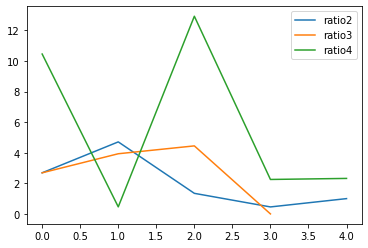

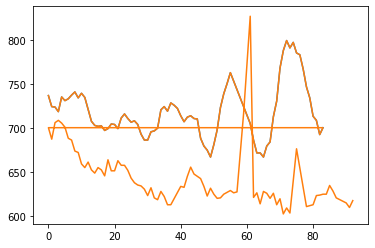

In [ ]:
import neurokit as nk
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pickle
import csv
import matplotlib.pyplot as plt
from biosppy import storage
from biosppy.signals import ecg

gdrive = True
gdrive_dir = '/content/drive/My Drive/School/UIUC/Research/Hsiao-Wecksler/M3X project proposal and reviews/csv'
file = '/content/drive/My Drive/School/UIUC/Research/Hsiao-Wecksler/M3X project proposal and reviews/csv/OA_2019_302_NW2_Rep_1.5.csv';


with open(gdrive_dir+'/HRV_measure.pickle', "rb") as fp:   # Unpickling
  HRV_measure = pickle.load(fp) 
with open(gdrive_dir+'/HRV_measure2.pickle', "rb") as fp:   # Unpickling
  HRV_measure2 = pickle.load(fp)
with open(gdrive_dir+'/HRV_measure3.pickle', "rb") as fp:   # Unpickling
  HRV_measure3 = pickle.load(fp)
with open(gdrive_dir+'/HRV_measure4.pickle', "rb") as fp:   # Unpickling
  HRV_measure4 = pickle.load(fp)

lfhf_measure = []
lfhf_measure2 = [] 
lfhf_measure3 = []
lfhf_measure4 = []
R_R = []
R_R2 = []
R_R3 = []
R_R4 = []

for i in range(len(HRV_measure)):
  try:
    lfhf_measure.append(HRV_measure[i]['LF/HF'])
  except:
    lfhf_measure.append(0)
  try:
    R_R.append( HRV_measure[i]['RR_Intervals'])
  except:
    R_R.append(0)

for i in range(len(HRV_measure2)):
  try:
    lfhf_measure2.append(HRV_measure2[i]['LF/HF'])
  except:
    lfhf_measure2.append(0)
  try:
    R_R2.append(HRV_measure2[i]['RR_Intervals'])
  except:
    R_R2.append(0)
  
for i in range(len(HRV_measure3)):
  
  try:
    lfhf_measure3.append(HRV_measure3[i]['LF/HF'])
  except:
    lfhf_measure3.append(0)
  try:
    R_R3.append(HRV_measure3[i]['RR_Intervals'])
  except:
    R_R3.append(0)
for i in range(len(HRV_measure4)):
  try:
    lfhf_measure4.append( HRV_measure4[i]['LF/HF'])
  except:
    lfhf_measure4.append(0)
  try:
    R_R4.append( HRV_measure4[i]['RR_Intervals'])
  except:
    R_R4.append(0)




#plt.plot(lfhf_measure)
plt.plot(lfhf_measure2)
plt.plot(lfhf_measure3)
plt.plot(lfhf_measure4)
plt.legend(['ratio2','ratio3','ratio4'])

plt.figure()

plt.plot(R_R[0])
plt.plot( , R_R[0].append(R_R[1]))
'''
plt.figure()
plt.plot(R_R2)
plt.figure()
plt.plot(R_R3)
plt.figure()
plt.plot(R_R4)
'''

#HRV_measure3 = pickle.load(fp)
#HRV_measure4 = pickle.load(fp)


In [ ]:
print(len(R_R[0]))
hesham = R_R[0].append(R_R[1])
print(len(hesham))
hesham = hesham.append(R_R[2])
print(len(hesham))
hesham = hesham.append(R_R[3])
hesham

79
163
253


0     736.979167
1     724.479167
2     723.958333
3     718.750000
4     735.416667
         ...    
78    610.416667
79    619.270833
80    617.708333
81    607.291667
85    609.895833
Length: 329, dtype: float64

## ?

bio2_1


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


    Using multitaper spectrum estimation with 7 DPSS windows
bio2_2


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


    Using multitaper spectrum estimation with 7 DPSS windows
bio2_3


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


    Using multitaper spectrum estimation with 7 DPSS windows
plot
bio2_1_1


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


    Using multitaper spectrum estimation with 7 DPSS windows
zplots


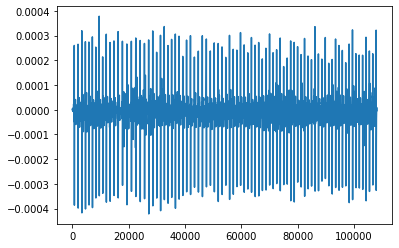

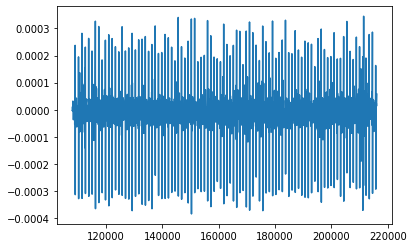

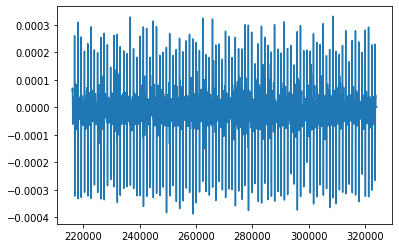

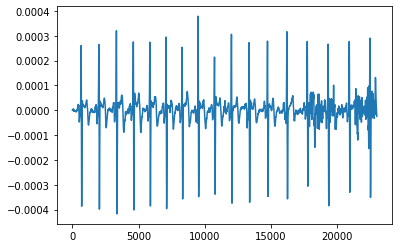

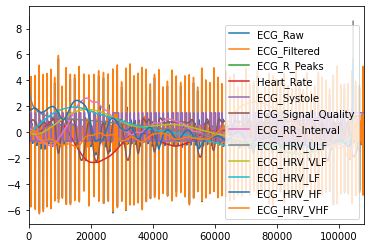

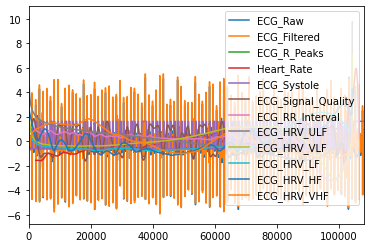

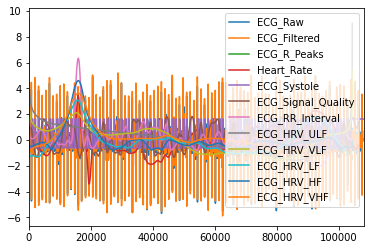

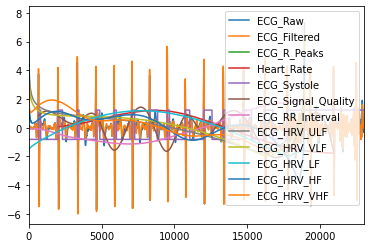

In [ ]:
# bio2 = nk.bio_process(ecg=df2['ECG'] , sampling_rate=1920);

df2 = pd.read_csv(file2);
df2 = df2.rename(columns={"0.000000000000000": "ECG"});
df['ECG']= df['ECG'][0:-364]

#plt.plot(df2['ECG'][(i)*interval:(i+1)*interval])
plt.figure()
plt.plot(df2['ECG'][0:108064])
plt.figure()
plt.plot(df2['ECG'][108064:216128])
plt.figure()
plt.plot(df2['ECG'][216128:324192])

df2_1 = df2['ECG'][0:108064] 
df2_2 = df2['ECG'][108064:216128]
df2_3 = df2['ECG'][216128:324192]

print('bio2_1')
bio2_1 = nk.bio_process(ecg=df2_1, sampling_rate=1920);
print('bio2_2')
bio2_2 = nk.bio_process(ecg=df2_2, sampling_rate=1920);
print('bio2_3')
bio2_3 = nk.bio_process(ecg=df2_3, sampling_rate=1920);

print('plot')

plt.figure()
# 10,000 waves didn't work (8.5)
# 13,000 did work (about 10 cycles looks like the minimum) without returning error but lf/hf ratio is 0
#
plt.plot(df2['ECG'][0:23006])
df2_1_1 = df2['ECG'][0:23006]

print('bio2_1_1')
bio2_1_1 = nk.bio_process(ecg=df2_1_1, sampling_rate=1920);

print('zplots')
nk.z_score(bio2_1["df"]).plot();
nk.z_score(bio2_2["df"]).plot();
nk.z_score(bio2_3["df"]).plot();
nk.z_score(bio2_1_1["df"]).plot();


In [ ]:

print(bio2_1["ECG"]['HRV']['LF/HF']) 
print(bio2_2["ECG"]['HRV']['LF/HF']) 
print(bio2_3["ECG"]['HRV']['LF/HF'] )
print(bio2_1_1["ECG"]['HRV']['LF/HF'] )
print(bio2_1_1["ECG"]['HRV'].keys())
print(bio2_1_1["ECG"]['HRV'])

75.23027904561395
67.09687267205048
0.9039546090229609
0.0
dict_keys(['n_Artifacts', 'RR_Intervals', 'RMSSD', 'meanNN', 'sdNN', 'cvNN', 'CVSD', 'medianNN', 'madNN', 'mcvNN', 'pNN50', 'pNN20', 'Triang', 'Shannon_h', 'ULF', 'VLF', 'LF', 'HF', 'VHF', 'Total_Power', 'LFn', 'HFn', 'LF/HF', 'LF/P', 'HF/P'])
{'n_Artifacts': 0.0, 'RR_Intervals': 0     697.916667
1     691.145833
2     665.104167
3     651.562500
4     639.062500
5     630.729167
6     630.729167
7     643.750000
8     667.708333
9     694.270833
10    724.479167
11    764.583333
12    801.041667
13    822.916667
14    830.729167
dtype: float64, 'RMSSD': 22.315661457365806, 'meanNN': 703.7152777777776, 'sdNN': 69.77913518743702, 'cvNN': 0.09915819279608165, 'CVSD': 0.0317112078734956, 'medianNN': 691.1458333333334, 'madNN': 47.39583333333337, 'mcvNN': 0.06857573474001512, 'pNN50': 0.0, 'pNN20': 46.666666666666664, 'Triang': 757.4602958957252, 'Shannon_h': 4.643856189774723, 'ULF': 0.0, 'VLF': 0.0, 'LF': 0.0, 'HF': 1801632.21895

## Algar3awi's



In [ ]:
# Computation
import numpy as np
import pandas as pd
from scipy import signal

# Plotting
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.io as pio
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline

# fs: sampling frequency
# df: reading a csv file and store it in panads dataframe (http://pandas.pydata.org/pandas-docs/stable/)

fs = 1920  
df = pd.read_csv('txt/OA_2019_302_NW1_Rep_1.2.txt')[:100000]
df = df.reset_index(drop=True)

# Select the ppg signal in the df dataframe.
print ('Total number of samples:', df.shape[0])
print ('In time scale:', df.shape[0]/(fs*60), 'mins')
print ('In time scale:', df.shape[0]/(fs), 'secs')
# downsampling by 20
factor = 10
new_index = np.arange(0,len(df), factor)
df = df.loc[new_index].reset_index(drop=True)
df = df.rename(columns={"0.000000000000000": "IR"});

fs = int(np.round(fs/factor))
ppg = df['IR']

### AMPD Algorithm
## Initialization
# N: total No. of samples
# L: number of scales
# alpha: constant factor 
# M: Local Maxima Scalogram matrix (initialize with random numbers)
# M_reshaped: Local Maxima Scalogram matrix, reshaped to the scales of interest.

N =  ppg.shape[0]                           
L = int(2*fs)       
alpha =10;                                
M = alpha + np.abs(np.random.randn(L,N))
M_reshaped =0

print ('N = ', N)
print ('L = ', L)
print ('M = ', M.shape)
# L: number of scales
# k: scale (frequency resolution)

for k in range(0, int(L)): 
    for i in range(k+1, N-k-1):
        if (ppg[i]>ppg[i-k-1] and ppg[i]>ppg[i+k+1]):
            M[k,i]=0;

gamma = np.sum(M, axis=1)
chosen = np.argmin(gamma)
print ('number of chosen rows = ', chosen)

plt.figure(figsize=(8,4))
plt.plot(gamma)
plt.title('Finding the scale (row) which holds the global minimum')
plt.ylabel('value of the resulted row-wise sum')
plt.xlabel('scales (L)')
plt.show()

# M_reshaped: Local Maxima Scalogram matrix, reshaped to the scales of interest.
# standard: shape N 
#           the standard deviation of the reshaped M matrix in the x-axis.

M_reshaped = M[0:chosen,:]
standard = np.std(M_reshaped, axis=0)

# peakLocations: ppg peaks locations in samples.
# peakLocations_time: ppg peaks locations in time (s)
# RR intervals in ms

peakLocations = np.where(standard==0)[0]
peakLocations_time = peakLocations/fs;
RR = np.diff(peakLocations_time) * 1000;  

# For better visualization, slice the M matrix up to some sample.
sample = 1000
ax =plt.figure(figsize=(20,40))
plt.imshow(M_reshaped[:,:sample], aspect=sample/100);
plt.title('Local Maxima Scalogram matrix (LMS)')
plt.ylabel('scale (k)')
plt.xlabel('sample')

def time_measurements(RR,x):
    # Parameters: RR: RR intervals in ms
    #        x: threshold in ms, typically: 50
    # return: a dict holds the time domain measurements: pnnx, rmssd (please check the definition of pnnx, rmssd on the table1 above)
    
    # IRI: the difference between RR intervals    

    IRI = np.abs(np.diff(RR))
    n=np.sum(IRI > x)
    pnnx=(n/len(IRI))*100

    rmssd = np.sqrt(np.mean(IRI ** 2))
    
    return dict(zip(['pnnx', 'rmssd'],
                    [pnnx, rmssd]))
  
time_measurements(RR, 50)
def freq_measurements(RR, fs, bands, method='periodogram', plotting=True):
    # Estimatation of the power spectral density (PSD).
    # Parameters: RR: RR intervals in ms
    #             fs: sampling frequency of the RR signal (not the ppg)
    #             method: method used to estimate the power spectral density (PSD).
    #             plotting: True if you want to plot the PSD.
    # return: a dict holds some freq domain measurements.
    #         very low frequency (vlf), low frequency (lf), and high frequency (hf) components. 
    #         LF/HF ratio (lf_hf),  normalized vlues of the high and low frequencies (lfnu, hfnu)
    # (please check the definitions in this paper: 
    # the Malik, M., Bigger, J. T., Camm, A. J., Kleiger, R. E., Malliani, A., Moss, A. J., & Schwartz, P. J. (1996). Heart rate variability: Standards of measurement, physiological interpretation, and clinical use. European heart journal, 17(3), 354-381.)
    
    # f: Array of sample frequencies.
    # Pxx_den: Power spectral density or power spectrum of x.
    
    # For implementation functions, refer to: 
    #                  https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.periodogram.html
    #                  https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.welch.html
    #                  https://docs.scipy.org/doc/numpy-1.9.2/reference/generated/numpy.trapz.html#numpy.trapz
    
    # using two methods:
    if method == 'periodogram':
        f, Pxx_den = signal.periodogram(x=RR, fs=fs)
    elif method == 'welch':
        f, Pxx_den = signal.welch(x=RR, fs=fs)
        
    # finding the indices of each band.
    vlf_indices = np.logical_and(f>= bands['vlf'][0], f < bands['vlf'][1])
    lf_indices = np.logical_and(f>= bands['lf'][0], f < bands['lf'][1])
    hf_indices = np.logical_and(f>= bands['hf'][0], f < bands['hf'][1])
    
    # integrate the power spectral density at each band.
    vlf = np.trapz(y=Pxx_den[vlf_indices], x=f[vlf_indices])
    lf = np.trapz(y=Pxx_den[lf_indices], x=f[lf_indices])
    hf = np.trapz(y=Pxx_den[hf_indices], x=f[hf_indices])
    
    total_power = vlf + lf + hf
    lf_hf = lf / hf
    lfnu = (lf / (total_power - vlf)) * 100
    hfnu = (hf / (total_power - vlf)) * 100
    
    if plotting:
        trace1 = go.Scatter(
            x = f,
            y = Pxx_den,
            mode = 'lines'
        )

        layout = go.Layout(
            title='power spectral density  (PSD)',
            xaxis=dict(title= 'Frequency (Hz)'),
            yaxis=dict(title= 'PSD'),
        )

        data = [trace1]
        fig= go.Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)
        
    return dict(zip(['total_power', 'vlf', 'lf', 'hf', 'lf_hf', 'lfnu','hfnu'],
                    [total_power, vlf, lf, hf, lf_hf, lfnu, hfnu]))
bands = {'vlf': (0, 0.04), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
freq_measurements(RR, 1.0, bands)

bands = {'vlf': (0, 0.04), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
freq_measurements(RR, 1.0, bands, method='welch')

In [ ]:
import argparse, os

parser = argparse.ArgumentParser()
parser.add_argument('--vocab_size', type=int, default=100000, help='# vocabulary size')
parser.add_argument('--algo', type=str, default='lstm', choices=['lstm', 'bi-lstm','attention'])
parser.add_argument('--max_token_seq_len', type=int, default=100, help='# maximum token sequence length')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--n_hidden_units', type=int, default=500, help='number of hidden units')
parser.add_argument('--optimizer', type=str, default='adam', choices=['adam', 'sgd'])
parser.add_argument('--batch_size', type=int, default=200, help='batch size')
parser.add_argument('--epochs', type=int, default=1000, help='number of epochs')
parser.add_argument('--user', type=str, default='giusy', choices=['giusy', 'abdul'] )
parser.add_argument('--loss', type=str, default='logits loss', choices = ['logits', 'cross'])
parser.add_argument('--machine', type=str, default='colab', choices=['colab','bluewater'])

args = parser.parse_known_args()[0]
